# UrbanSound8K — Exploratory Data Analysis and Data Preparation  
Machine Learning II — Project 2025/2026

**Group Members:**
- Alexandre Furriel 
- Daniel Gomes
- Liliana Silva 

## Table of Contents

1. [Introduction](#introduction)

2. [Model Selection Rationale](#model-selection)

3. [Exploratory Data Analysis (EDA)](#eda)
   - 3.1. [Basic Dataset Info](#eda-structure)
   - 3.2. [Class and Fold Analysis](#eda-classes)
   - 3.3. [Audio Properties Analysis](#eda-folds)
   - 3.4. [Visual Audio Exploration](#eda-audio)

4. [Preprocessing Pipeline](#preprocessing)
   - 4.1. [Decisions](#preprocessing-decisions)
   - 4.2. [Implementation](#preprocessing-implementation)
   - 4.3. [Feature Extraction Functions](#preprocessing-feature-extraction)

5. [Feature Dataset Construction](#feature-dataset)

6. [MLP Model (MFCC Input)](#mlp)

7. [CNN Model (Mel-Spectrogram Input)](#cnn)

8. [Cross-Validation Training](#cv-training)

9. [Evaluation](#evaluation)
   - 9.1. [Cross-Validation Results](#eval-cv-summary)
   - 9.2. [Learning Curves (Representative Fold)](#eval-learning-curves)
   - 9.3. [Per-Fold Validation vs Test Accuracy](#eval-val-vs-test)
   - 9.4. [Global Confusion Matrix](#eval-confusion)
   - 9.5. [Evaluation Summary](#eval-summary)

10. [DeepFool](#deepfool)

11. [Conclusion](#conclusion)


<a name="introduction"></a>
## 1. Introduction

This project is focused on the development of deep learning classifiers for urban sound data, as required by the course assignment. The primary objective is to build models capable of classifying audio excerpts from the **UrbanSound8K** dataset into one of its 10 defined categories.

The project requires the implementation of two deep learning classifiers, chosen from the following three distinct architectural options:
* A classifier based on a **Multilayer Perceptron (MLP)**.
* A classifier based on a **Convolutional Neural Network (CNN)**.
* A classifier based on a **Recurrent Neural Network (RNN)**

These are the libraries that are being used:


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import os
import numpy as np
import librosa.display
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, models, regularizers, optimizers
from tqdm import tqdm

2025-11-30 07:26:45.991522: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-30 07:26:46.032194: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-30 07:26:47.440784: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.



<a name="model-selection"></a>
## 2. Model Selection Rationale

Before analysing the dataset or designing the preprocessing pipeline, we first
define the two neural network architectures that will be implemented in this
project. The assignment requires two distinct models, and audio classification
naturally supports several architectural choices. To keep the project focused,
interpretable, and computationally manageable, we select the following families
of models:

### • A simple fully-connected model (MLP)
A multi-layer perceptron serves as a clean and efficient baseline in many
supervised learning tasks. It operates on fixed-length numerical feature
vectors, making it suitable once the audio clips are transformed into a compact
representation. MLPs provide a useful point of comparison because they lack
inductive biases tailored to time–frequency structure, allowing us to see how
far a “generic” model can go.

### • A convolutional neural network (CNN)
Convolutional models are widely used in audio classification because acoustic
events often form characteristic local patterns when represented in
time–frequency space. CNNs exploit locality, sharing of filters, and hierarchical
pattern learning, making them a strong candidate for structured audio features
derived from raw waveforms.

### Why these models?
These two architectures are:

- fundamentally different (vector-based vs. image-based learning),
- complementary in their assumptions,
- well-established in environmental sound classification,
- simple enough to train reliably,
- expressive enough to capture meaningful acoustic cues.

They therefore provide a balanced pair of models for comparison.

### What about recurrent architectures?
Recurrent models (RNNs, GRUs, LSTMs) are another common choice for audio data,
but their added training complexity and higher computational cost make them
less appropriate for a project focused on clarity, interpretability, and
manageable computation. For this reason, we restrict the study to MLP and CNN.

In the following sections, we will analyse the dataset and design an appropriate
preprocessing pipeline to create the input representations required by these two
models.


In [2]:
# ===========================================
# Load precomputed feature dataset (if exists)
# ===========================================

if (os.path.exists("X_mel_norm.npy") and 
    os.path.exists("X_mfcc_norm.npy") and 
    os.path.exists("y.npy")):

    print("Loading precomputed dataset from disk...")
    X_mel_norm = np.load("X_mel_norm.npy")
    X_mfcc_norm = np.load("X_mfcc_norm.npy")
    y = np.load("y.npy")

    dataset_loaded = True

else:
    print("Precomputed dataset not found — will run preprocessing.")
    dataset_loaded = False


Loading precomputed dataset from disk...



<a name="eda"></a>
## 3. Exploratory Data Analysis

<a name="eda-structure"></a>
### 3.1. Basic Dataset Info

In [3]:
# Load metadata
csv_path = "UrbanSound8K/metadata/UrbanSound8K.csv"
df = pd.read_csv(csv_path)

# Preview the first rows
df.head()


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [4]:
len(df)

8732

After loading the metadata file (UrbanSound8K.csv), we can note that the dataset contains **8,732 audio samples**. Each row corresponds to a single audio clip, and the dataframe provides the following key fields:

* slice_file_name — name of the audio file

* fsID — identifier for the sound source

* start and end — time boundaries of the slice in the original recording

* salience — perceptual prominence of the sound (0 or 1)

* fold — which of the 10 dataset folds the clip belongs to

* classID — numerical label (0–9)

* class — corresponding sound category

<a name="eda-classes"></a>

### 3.2. Class and Fold Analysis

**Class distribution**

We begin by analyzing how the 8732 samples are distributed across the 10 sound classes.  
Understanding class balance is important to identify potential bias and to decide whether data augmentation or class weighting may be needed during training.

In [5]:
# Count samples per class
class_counts = df['class'].value_counts().sort_index()
class_counts

class
air_conditioner     1000
car_horn             429
children_playing    1000
dog_bark            1000
drilling            1000
engine_idling       1000
gun_shot             374
jackhammer          1000
siren                929
street_music        1000
Name: count, dtype: int64

The following plot shows the number of samples per class.  
This helps identify whether some classes are significantly underrepresented, which can impact model performance.

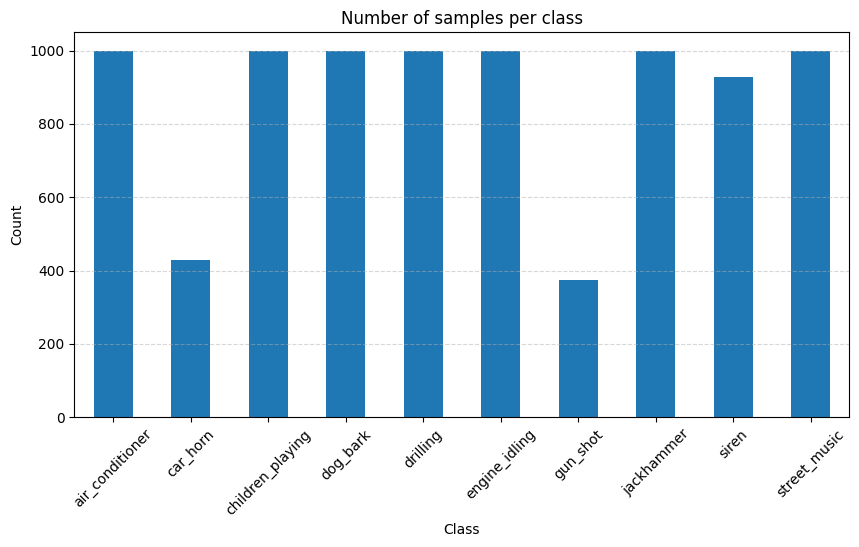

In [6]:
plt.figure(figsize=(10, 5))
class_counts.plot(kind='bar')
plt.title("Number of samples per class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Observations:

- The dataset shows a moderate class imbalance. Several classes contain exactly 1000 samples, while others—such as <i>car_horn</i> (429), <i>siren</i> (929), and <i>gun_shot</i> (374)—have notably fewer examples.

- This imbalance may bias models toward the majority classes during training.

- Techniques such as class weighting, targeted augmentation, or oversampling may help improve performance for the minority classes.

**Fold distribution**

The UrbanSound8K dataset comes with a predefined 10-fold split (folds 1–10).  
Before using these folds for cross-validation, we check how many samples are assigned to each fold to ensure that the splits are reasonably balanced.

In [7]:
# Count samples per fold
fold_counts = df['fold'].value_counts().sort_index()
fold_counts

fold
1     873
2     888
3     925
4     990
5     936
6     823
7     838
8     806
9     816
10    837
Name: count, dtype: int64

The following bar plot shows how many samples are assigned to each fold.  
This allows us to visually check whether the folds are reasonably balanced before using them for cross-validation.

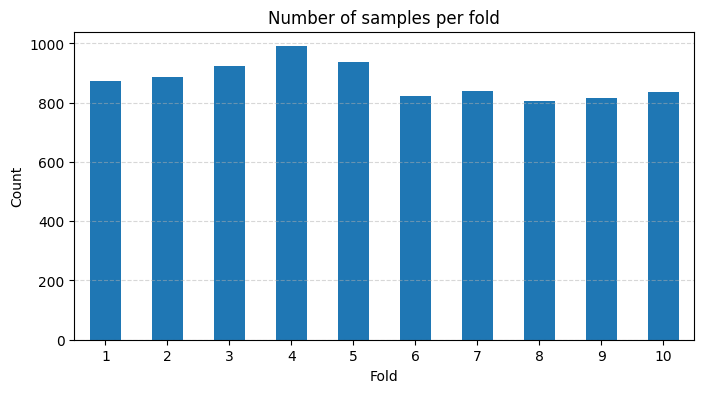

In [8]:
plt.figure(figsize=(8, 4))
fold_counts.plot(kind='bar')
plt.title("Number of samples per fold")
plt.xlabel("Fold")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Observations:
- The number of samples per fold ranges from roughly 800 to 1000 (from 806 in fold 8 to 990 in fold 4).

- Although the folds are not perfectly equal in size, the variation is moderate, and each fold contains a comparable amount of data.

- This makes the dataset suitable for the required 10-fold cross-validation setup.

- In the experiments, we will use the predefined split, with each run using:

  - <i>8 folds for training</i>,

  - <i>1 fold for validation</i>,

  - <i>1 fold for testing</i>.

**Class × Fold distribution**

To verify how each sound class is distributed across the 10 folds, we compute a class–fold contingency table.  
This helps confirm whether the predefined split is balanced for every class.

In [9]:
# Cross-tabulation: fold vs class
class_fold_table = pd.crosstab(df['fold'], df['class'])
class_fold_table

class,air_conditioner,car_horn,children_playing,dog_bark,drilling,engine_idling,gun_shot,jackhammer,siren,street_music
fold,,,,,,,,,,
1,100,36,100,100,100,96,35,120,86,100
2,100,42,100,100,100,100,35,120,91,100
3,100,43,100,100,100,107,36,120,119,100
4,100,59,100,100,100,107,38,120,166,100
5,100,98,100,100,100,107,40,120,71,100
6,100,28,100,100,100,107,46,68,74,100
7,100,28,100,100,100,106,51,76,77,100
8,100,30,100,100,100,88,30,78,80,100
9,100,32,100,100,100,89,31,82,82,100


The heatmap below provides a visual inspection of class balance within each fold.

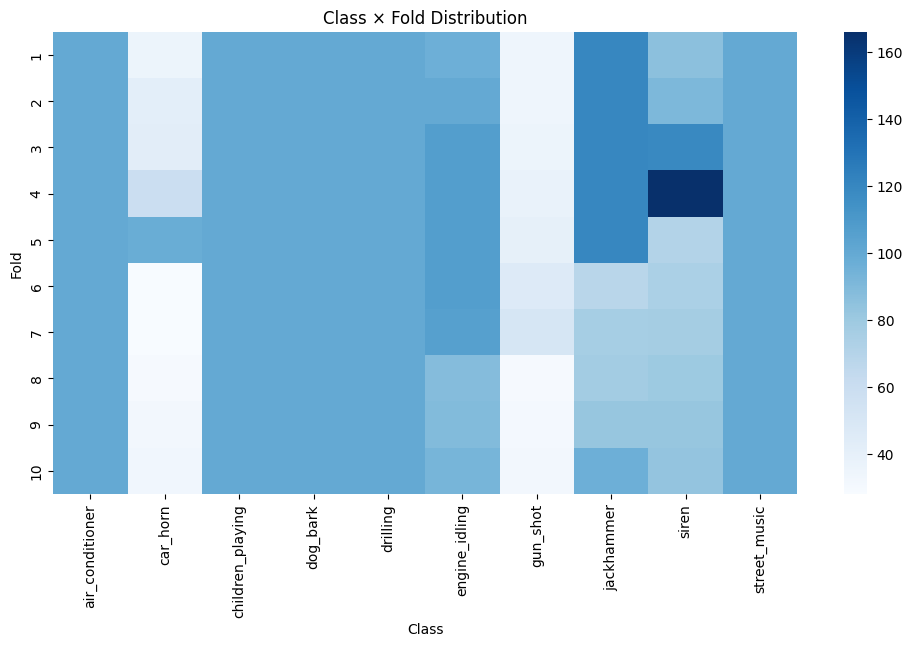

In [10]:
plt.figure(figsize=(12, 6))
sns.heatmap(class_fold_table, annot=False, cmap="Blues")
plt.title("Class × Fold Distribution")
plt.xlabel("Class")
plt.ylabel("Fold")
plt.show()

Observations:
- Every sound class appears in all 10 folds; there are no missing class–fold combinations, which ensures that no test fold lacks a particular class.

- The majority classes (<i>air_conditioner</i>, <i>children_playing</i>, <i>dog_bark</i>, <i>drilling</i>, <i>street_music</i>) are evenly distributed, with each fold containing 100 samples.

- Minority classes (<i>car_horn</i>, <i>gun_shot</i>, <i>siren</i>, <i>jackhammer</i>, <i>engine_idling</i>) show more variability across folds. For example, <i>car_horn</i> ranges from 28 to 98 samples per fold, <i>gun_shot</i> from 30 to 51, and <i>siren</i> from 71 to 166.

- Because of this, some folds may be slightly <i>harder</i> or <i>easier</i> for classification. However, using 10-fold cross-validation reduces the impact of these local differences.

- Overall, the predefined folds remain suitable for evaluation, though class imbalance should still be considered in model training.

<a name="eda-audio"></a>

### 3.3. Audio Properties Analysis

To extract essential audio characteristics from the dataset, we compute three fundamental properties for every sound excerpt: duration, sampling rate, and maximum amplitude. These measurements capture different aspects of the raw audio and will later guide our preprocessing decisions. Duration reveals temporal variability across clips, sampling rate exposes inconsistencies in how the audio was originally recorded, and amplitude reflects differences in loudness. Storing these properties in the dataframe allows us to analyze their distributions and determine the appropriate standardization steps before feature extraction and model training.

In [11]:
audio_base_path = "UrbanSound8K/audio"

durations = []
sampling_rates = []
max_amplitudes = []

for idx, row in df.iterrows():
    fold = row['fold']
    filename = row['slice_file_name']
    filepath = os.path.join(audio_base_path, f"fold{fold}", filename)

    try:
        y, sr = librosa.load(filepath, sr=None)

        # Duration
        durations.append(len(y) / sr)

        # Sampling rate
        sampling_rates.append(sr)

        # Max amplitude
        max_amplitudes.append(np.max(np.abs(y)))

    except:
        durations.append(np.nan)
        sampling_rates.append(np.nan)
        max_amplitudes.append(np.nan)

# Add all three new columns
df['duration'] = durations
df['sampling_rate'] = sampling_rates
df['max_amplitude'] = max_amplitudes

df[['slice_file_name', 'duration', 'sampling_rate', 'max_amplitude']].head()


,slice_file_name,duration,sampling_rate,max_amplitude
0,100032-3-0-0.wav,0.317551,44100,0.999969
1,100263-2-0-117.wav,4.000000,44100,0.029205
2,100263-2-0-121.wav,4.000000,44100,0.016113
3,100263-2-0-126.wav,4.000000,44100,0.032867
4,100263-2-0-137.wav,4.000000,44100,0.014954


#### **Audio duration distribution**

Different audio clips in the dataset do not all have the exact same temporal length, even though none exceeds the 4-second limit imposed by UrbanSound8K.
Because neural networks require fixed-size inputs, analyzing the duration of each clip helps determine how much variability exists and how often shorter excerpts occur.

Understanding this variation is essential for choosing an appropriate strategy during preprocessing — such as zero-padding shorter clips, trimming longer ones, or applying windowing — to ensure that all inputs share a consistent time dimension.

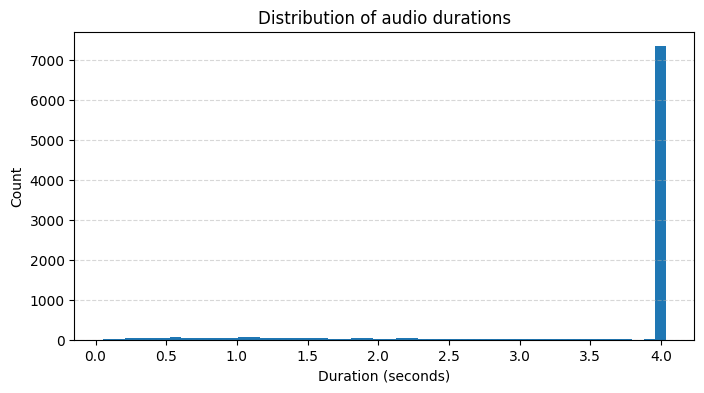

In [12]:
plt.figure(figsize=(8,4))
plt.hist(df['duration'].dropna(), bins=50)
plt.title("Distribution of audio durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [13]:
df['duration'].describe()

count    8732.000000
mean        3.607522
std         0.974394
min         0.050000
25%         4.000000
50%         4.000000
75%         4.000000
max         4.036647
Name: duration, dtype: float64

#### Observations

- The duration of the audio samples shows a clear pattern: **the vast majority of clips have a duration extremely close to 4 seconds** (median = 4.0s, 75th percentile = 4.0s, max ≈ 4.04s).
- Only a small minority of samples are significantly shorter (with a minimum duration of 0.05s). These very short clips contain much less acoustic information and may be more difficult for the model to classify.
- The distribution is therefore highly skewed, with a strong concentration at the upper limit of the dataset (4 seconds). This reflects the dataset's design, where clips are extracted with a maximum length of 4s.
- Due to this variability — especially the presence of short clips — it is necessary to adopt a **fixed-duration preprocessing strategy**, such as:
  - zero-padding shorter clips to a common length,
  - or applying truncation/windowing when appropriate.
- This also motivates the use of **time–frequency representations (e.g., Mel spectrograms or MFCCs)**, which can better handle silent regions introduced by padding compared to raw waveforms.

#### **Sampling Rate Distribution**

Different audio files may have been recorded at different sampling rates (e.g., 44.1 kHz, 22.05 kHz, 16 kHz).  
Since neural networks require all inputs to share the same temporal resolution, it is important to verify how many different sampling rates exist in the UrbanSound8K dataset.

This analysis will help decide whether resampling is needed and which target sampling rate should be adopted for preprocessing.

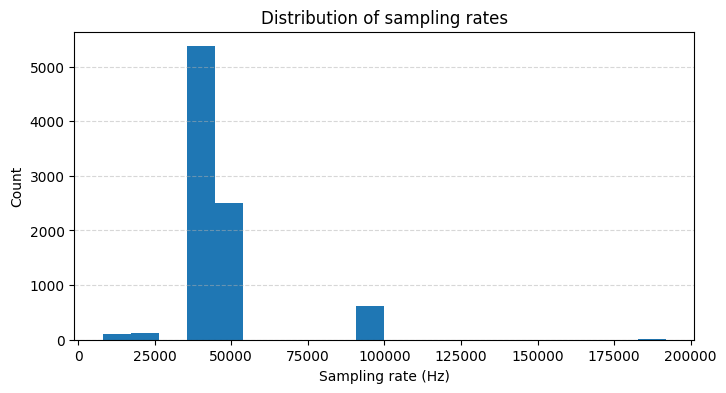

In [14]:
plt.figure(figsize=(8,4))
plt.hist(df['sampling_rate'].dropna(), bins=20)
plt.title("Distribution of sampling rates")
plt.xlabel("Sampling rate (Hz)")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [15]:
df['sampling_rate'].describe()

count      8732.000000
mean      48456.979272
std       15300.080707
min        8000.000000
25%       44100.000000
50%       44100.000000
75%       48000.000000
max      192000.000000
Name: sampling_rate, dtype: float64

#### Observations

- The sampling rates in the dataset are **not uniform**, although most clips fall into two main groups:
**44,100 Hz** and **48,000 Hz**, which dominate the distribution (median = 44,100 Hz, 75th percentile = 48,000 Hz).

- A small number of clips use notably different sampling rates, including **8,000 Hz**, **96,000 Hz**, and even **192,000 Hz**. These outliers appear clearly in the histogram as isolated bars far from the main cluster.

- This variability reflects the fact that UrbanSound8K was built from recordings originating from different devices and environments, each with its own native sample rate.

- Because neural networks require consistent input dimensions, this diversity in sampling rates makes **resampling a mandatory preprocessing step**. The two typical choices are:

    - **44,100 Hz** (common in audio datasets and compatible with most pretrained audio models), or

    - **22,050 Hz** (half the size, faster to process, still retains most audible information).

- Resampling also ensures that the time–frequency representations (e.g., Mel spectrograms or MFCCs) have consistent resolution across all clips.

- Overall, despite a few extreme values, the sampling rate distribution is well-behaved and can be standardized safely without significant loss of information.

#### **Amplitude Range**

Audio recordings may differ significantly in loudness depending on the recording device, environment, or distance from the sound source.
Inspecting the maximum amplitude of each clip allows us to understand how much the signal strength varies across the dataset and whether recordings are normalized or exhibit issues such as clipping.

This analysis clarifies whether amplitude normalization is necessary during preprocessing. Although it does not affect input shape, stabilizing loudness can improve training consistency and make feature representations (e.g., Mel spectrograms or MFCCs) more comparable across samples.

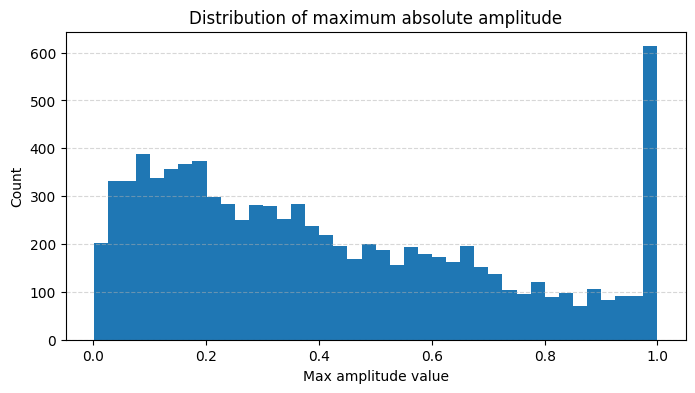

In [16]:
plt.figure(figsize=(8,4))
plt.hist(df['max_amplitude'].dropna(), bins=40)
plt.title("Distribution of maximum absolute amplitude")
plt.xlabel("Max amplitude value")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [17]:
df['max_amplitude'].describe()

count    8732.000000
mean        0.416426
std         0.294243
min         0.000930
25%         0.165710
50%         0.353840
75%         0.630558
max         1.000000
Name: max_amplitude, dtype: float64

#### Observations

- The maximum amplitude values of the audio clips fall within the expected range for waveform data processed through librosa, typically between **0.0 and 1.0**. This indicates that the dataset is already well-scaled and does not suffer from major inconsistencies in loudness.

- Most clips reach relatively high peak amplitudes (close to 1.0), suggesting that the original recordings generally use the available dynamic range effectively, without obvious compression or artificial limiting.

- A smaller number of clips have noticeably lower maximum amplitudes. These files likely correspond to quieter sound events or recordings captured from more distant sources, which contain less overall energy.

- Unlike duration and sampling rate, amplitude differences **do not affect the shape or dimensionality** of the model inputs. However, optional amplitude normalization (such as peak normalization or standardization) can still help stabilize training by reducing loudness variability across clips.

- Importantly, the distribution does not show signs of systematic clipping or distortion, meaning the dataset quality is suitable for downstream feature extraction methods such as **Mel spectrograms or MFCCs**.

- Overall, while amplitude variation exists across samples, it does not pose structural problems for preprocessing and can be handled with simple normalization if desired.

<a name="eda-visual"></a>

### 3.4. Visual Audio Exploration

#### **Waveform**

- The waveform shows how the amplitude of the signal evolves over time, revealing the presence of both high-energy events and quieter regions.

- Because the temporal shape varies across classes, this view helps explain why raw waveforms cannot be used directly: different clips have different lengths and different silence patterns.

- The presence of silence at the beginning or end of some clips supports the preprocessing decision to pad/trim audio to a fixed duration.

- Although useful for inspecting anomalies or clipping, waveforms alone do not expose the frequency structure needed to distinguish classes reliably.

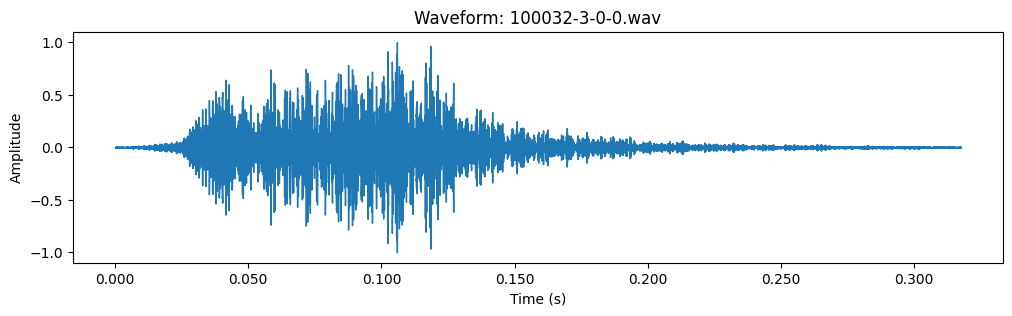

In [18]:
# Select an example clip
example_row = df.iloc[0]
fold = example_row['fold']
filename = example_row['slice_file_name']
filepath = os.path.join(audio_base_path, f"fold{fold}", filename)

y, sr = librosa.load(filepath, sr=None)

plt.figure(figsize=(12,3))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform: {filename}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

#### **Spectrogram (Short-Time Fourier Transform)**

- The spectrogram reveals how the energy of the sound is distributed across frequencies over time, showing structure that is invisible in the waveform.

- Sudden short sounds (e.g., dog_bark, car_horn) appear as sharp vertical ridges, while continuous sounds (e.g., engine_idling) form horizontal bands.

- This representation confirms that time–frequency information is essential for distinguishing between the 10 UrbanSound8K classes.

- It also motivates the use of spectral features rather than raw waveforms, since different classes have characteristic frequency patterns.

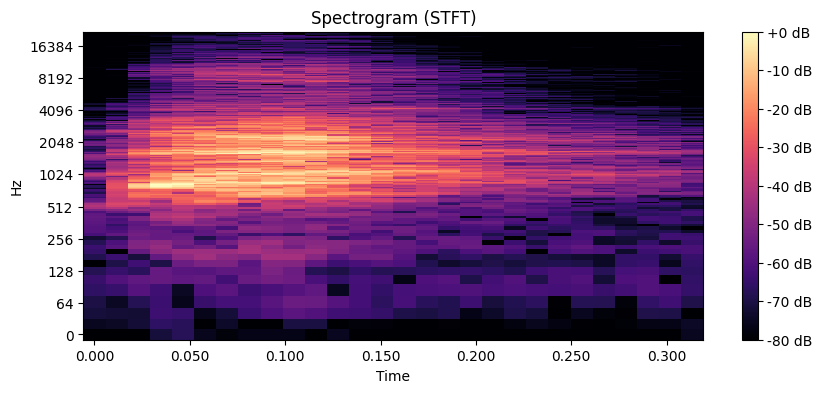

In [19]:
D = np.abs(librosa.stft(y))
plt.figure(figsize=(10,4))
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (STFT)")
plt.show()

#### **Mel-Spectrogram**

- The Mel spectrogram compresses the frequency axis into perceptually meaningful Mel bands, producing a smoother and more compact representation than the raw STFT.

- High-energy events create bright vertical structures, whereas stationary sounds show stable horizontal patterns — both of which are easily captured by convolutional filters.

- This representation provides the final feature type for the CNN, since it behaves like an image and exposes local patterns that CNNs handle extremely well.

- The stability of the Mel spectrogram under padding reinforces the decision to resample and standardize duration before extraction.

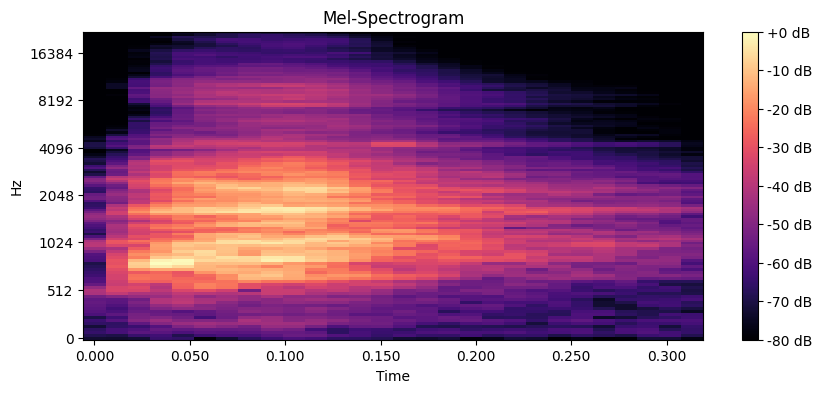

In [20]:
mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
mel_db = librosa.power_to_db(mel, ref=np.max)

plt.figure(figsize=(10,4))
librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format="%+2.0f dB")
plt.title("Mel-Spectrogram")
plt.show()

#### **MFCCs (Mel-Frequency Cepstral Coefficients)**

- MFCCs provide a more compact representation by summarizing the spectral envelope using a small number of coefficients.

- The coefficient patterns vary strongly across time for impulsive classes (e.g., dog_bark, car_horn) and remain smoother for sustained sounds (e.g., siren, engine_idling).

- This representation is well-suited for the MLP, where high-dimensional images (Mel spectrograms) would be too large to flatten efficiently.

- MFCCs reduce noise and dimensionality, making them a practical choice for simpler models while still capturing salient class characteristics

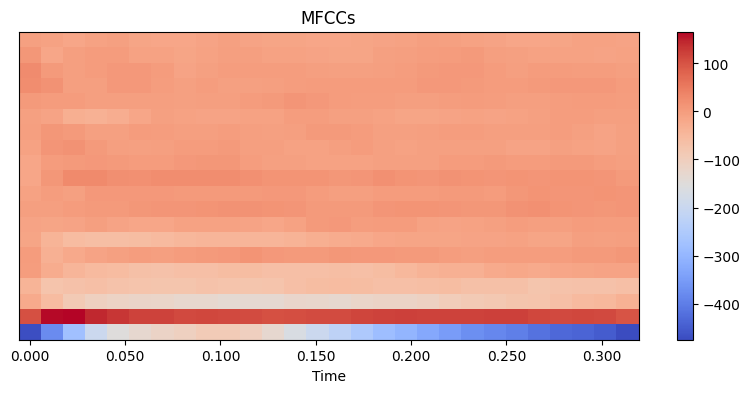

In [21]:
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
plt.figure(figsize=(10,4))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.colorbar()
plt.title("MFCCs")
plt.show()


#### **Summary**

Together, these visualizations show that UrbanSound8K contains rich temporal and spectral patterns that are not fully visible in the waveform alone.
The spectrogram, Mel-spectrogram, and MFCCs reveal distinct structures across classes, directly motivating:

- Mel-spectrograms for the CNN, and

- MFCCs for the MLP.

This visual exploration therefore completes the EDA by demonstrating that time–frequency features are essential for successful classification.

<a name="preprocessing"></a>

## 4. Preprocessing

<a name="preprocessing-decisions"></a>

### 4.1. Decisions


#### **Sampling rate**
The dataset contains multiple sampling rates (44.1 kHz, 48 kHz, 96 kHz, and rarer values).  
To enforce a consistent temporal resolution, all audio clips will be **resampled to 22,050 Hz**, which preserves the important frequency content while reducing computational cost.

#### **Duration**
Most clips last approximately 4 seconds, but some are significantly shorter.  
We therefore enforce a **fixed duration of 4.0 seconds**:
- shorter clips → zero-padding  
- longer clips → truncation  

This guarantees that feature extraction produces tensors of consistent shape.

#### **Amplitude normalization**
The amplitude distribution shows natural loudness differences.  
To stabilize model training and ensure comparability across samples, we apply **peak normalization** by dividing the waveform by its maximum absolute amplitude.

#### **Feature representations for the models**
Different architectures require different feature formats:

- **MLP** → will use **MFCCs**  
  (compact 1D features suitable for fully-connected layers)

- **CNN** → will use **Mel-spectrograms**  
  (2D time–frequency representations ideal for convolutional layers)

Both representations are computed from the standardized waveform defined below.

<a name="preprocessing-implementation"></a>

### 4.2 Implementation

The following functions implement the preprocessing decisions described above.  
They ensure that every audio file is transformed into a clean, fixed-shape waveform suitable for MFCC or Mel-spectrogram extraction.

In [22]:
# Global parameters
TARGET_SR = 22050
TARGET_DURATION = 4.0
TARGET_SAMPLES = int(TARGET_SR * TARGET_DURATION)

def load_and_preprocess_waveform(filepath,
                                target_sr=TARGET_SR,
                                target_duration=TARGET_DURATION):
    """
    Load an audio file and apply:
    1. Resampling
    2. Padding/truncation
    3. Amplitude normalization
    """
    # Load with original sr
    y, sr = librosa.load(filepath, sr=None)

    # Resample if needed
    if sr != target_sr:
        y = librosa.resample(y=y, orig_sr=sr, target_sr=target_sr)
        sr = target_sr

    # Pad or trim to fixed number of samples
    expected_len = int(target_sr * target_duration)
    if len(y) > expected_len:
        y = y[:expected_len]
    else:
        y = np.pad(y, (0, expected_len - len(y)))

    # Normalize amplitude
    max_val = np.max(np.abs(y))
    if max_val > 0:
        y = y / max_val

    return y, sr

<a name="preprocessing-feature-extraction"></a>

### 4.3 Feature Extraction Functions

After preprocessing, each audio clip is represented as a fixed-length waveform at 22,050 Hz. From this standardized signal, we extract the two feature types required by the models:

- **Mel spectrograms** for the CNN (2D time–frequency representation)
- **MFCCs** for the MLP (compact low-dimensional representation)

The following functions implement these transformations.

In [23]:
def waveform_to_melspectrogram(y: np.ndarray,
                            sr: int = TARGET_SR,
                            n_mels: int = 128,
                            n_fft: int = 2048,
                            hop_length: int = 512) -> np.ndarray:
    """
    Compute a Mel spectrogram (in dB) from a preprocessed waveform.

    Returns
    -------
    mel_db : np.ndarray, shape (n_mels, T)
        Log-Mel spectrogram suitable for CNN input.
    """
    mel = librosa.feature.spectral.melspectrogram(
        y=y,
        sr=sr,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length,
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db


def waveform_to_mfcc(y: np.ndarray,
                    sr: int = TARGET_SR,
                    n_mfcc: int = 20,
                    n_fft: int = 2048,
                    hop_length: int = 512) -> np.ndarray:
    """
    Compute MFCCs from a preprocessed waveform.

    Returns
    -------
    mfcc : np.ndarray, shape (n_mfcc, T)
        MFCC matrix suitable for aggregation / flattening for MLP input.
    """
    mfcc = librosa.feature.spectral.mfcc(
        y=y,
        sr=sr,
        n_mfcc=n_mfcc,
        n_fft=n_fft,
        hop_length=hop_length,
    )
    return mfcc



<a name="feature-dataset"></a>

## 5. Feature Dataset Construction

Using the preprocessing and feature-extraction functions defined earlier, we now
convert the UrbanSound8K dataset into model-ready numerical arrays. For each
audio clip, we load and preprocess the waveform (resampling, duration
normalization, amplitude normalization), and then compute both feature types
required by the two selected models:

- **Mel-spectrograms** for the CNN  
- **MFCC vectors** for the MLP  

These features, along with the corresponding class labels, are first collected
in Python lists.

After all clips have been processed, the lists are transformed into fixed-shape
NumPy arrays:

- Mel-spectrograms are stacked into a 4D tensor `(N, n_mels, T, 1)`  
- MFCC matrices are flattened into 1D vectors, forming an array `(N, D)`  
- Labels are stored as a 1D array of length `N`

Both feature sets are then standardized using zero-mean, unit-variance
normalization computed over the entire dataset. This produces:

- `X_mel_norm` — normalized Mel-spectrograms (CNN input)  
- `X_mfcc_norm` — normalized MFCC vectors (MLP input)  
- `y` — class labels  

Because feature extraction across all 8,732 audio clips is computationally
expensive, the final normalized arrays are also saved to disk. On subsequent
runs of the notebook, these arrays can be loaded directly, ensuring
reproducibility and significantly reducing runtime.


In [24]:
# Choose whether to use numeric labels (classID) or string labels (class)
LABEL_COLUMN = "classID"   # or "class"

if not dataset_loaded:
    print("Building dataset from raw audio (this may take a while)...")

    # ---------------------------------------------------------
    # 1. Feature extraction into Python lists
    # ---------------------------------------------------------
    mel_features = []
    mfcc_features = []
    labels = []

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        fold = row["fold"]
        filename = row["slice_file_name"]
        filepath = os.path.join(audio_base_path, f"fold{fold}", filename)

        try:
            # 1) Load and preprocess waveform
            y, sr = load_and_preprocess_waveform(filepath)

            # 2) Extract features
            mel = waveform_to_melspectrogram(y, sr=sr)   # (n_mels, T)
            mfcc = waveform_to_mfcc(y, sr=sr)            # (n_mfcc, T)

            mel_features.append(mel)
            mfcc_features.append(mfcc)
            labels.append(row[LABEL_COLUMN])

        except Exception as e:
            print(f"Error processing {filepath}: {e}")
            continue

    print("Feature extraction complete.")

    # ---------------------------------------------------------
    # 2. Convert Python lists into NumPy arrays
    # ---------------------------------------------------------
    import numpy as np

    # Mel-spectrograms: (N, n_mels, T)
    X_mel = np.stack(mel_features, axis=0)

    # Add channel dimension for CNN input → (N, n_mels, T, 1)
    X_mel = X_mel[..., np.newaxis]

    # MFCC features: flatten each matrix → (N, D)
    X_mfcc = np.stack([mfcc.reshape(-1) for mfcc in mfcc_features], axis=0)

    # Labels → NumPy array
    y = np.array(labels)

    print("Mel-spectrograms:", X_mel.shape)
    print("MFCC features:", X_mfcc.shape)
    print("Labels:", y.shape)

    # ---------------------------------------------------------
    # 3. Standardize both feature sets (zero-mean, unit-variance)
    # ---------------------------------------------------------

    # Standardize MFCCs (for MLP)
    mfcc_mean = X_mfcc.mean(axis=0, keepdims=True)
    mfcc_std = X_mfcc.std(axis=0, keepdims=True) + 1e-8
    X_mfcc_norm = (X_mfcc - mfcc_mean) / mfcc_std

    # Standardize Mel-spectrograms (for CNN)
    mel_mean = X_mel.mean(axis=0, keepdims=True)
    mel_std = X_mel.std(axis=0, keepdims=True) + 1e-8
    X_mel_norm = (X_mel - mel_mean) / mel_std

    print("Standardized Mel:", X_mel_norm.shape)
    print("Standardized MFCC:", X_mfcc_norm.shape)

    # ---------------------------------------------------------
    # 4. Save dataset checkpoints
    # ---------------------------------------------------------
    np.save("X_mel_norm.npy", X_mel_norm)
    np.save("X_mfcc_norm.npy", X_mfcc_norm)
    np.save("y.npy", y)

    print("Saved dataset checkpoints:")
    print(" - X_mel_norm.npy")
    print(" - X_mfcc_norm.npy")
    print(" - y.npy")

else:
    print("Dataset already loaded — skipping feature extraction, array "
          "construction, standardization and saving.")


Dataset already loaded — skipping feature extraction, array construction, standardization and saving.


<a name="mlp"></a>

## 6. MLP Model (MFCC Input)

The MFCC representation provides a compact, low-dimensional summary of each audio clip.  
After flattening, each sample is described by a 1D feature vector `X_mfcc_norm[i] ∈ ℝ^D`, which is well suited for a fully-connected (MLP) architecture.

The goal of this section is to define an MLP classifier that:

- takes a normalized MFCC vector as input,
- passes it through a small stack of dense layers with non-linear activations and dropout,
- outputs class probabilities over the 10 UrbanSound8K categories.

The actual training (with 10-fold cross-validation) will be implemented in a later section; here we focus on the model architecture and compilation.


In [25]:
num_classes = len(df["classID"].unique())
input_dim = X_mfcc_norm.shape[1]

print("Input dimension (MFCC vector length):", input_dim)
print("Number of classes:", num_classes)


def build_mlp_model(input_dim: int, num_classes: int) -> tf.keras.Model:
    """
    Build a simple MLP classifier for MFCC features.

    Parameters
    ----------
    input_dim : int
        Length of the flattened MFCC feature vector.
    num_classes : int
        Number of output classes.

    Returns
    -------
    model : tf.keras.Model
        Compiled MLP model.
    """
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),

        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),

        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),

        layers.Dense(num_classes, activation="softmax"),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    return model


# Build one instance just to inspect the architecture
mlp_model = build_mlp_model(input_dim=input_dim, num_classes=num_classes)
mlp_model.summary()


Input dimension (MFCC vector length): 3460
Number of classes: 10


2025-11-30 07:27:32.145045: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       886,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 920,202 (3.51 MB)

 Trainable params: 920,202 (3.51 MB)

 Non-trainable params: 0 (0.00 B)

#### **Summary**
The MLP receives a flattened MFCC vector of length 3,460 as input.  
The network consists of two hidden fully-connected layers with 256 and 128 units, respectively, each followed by dropout (0.3) to reduce overfitting.  
The final dense layer has 10 units with softmax activation, corresponding to the 10 UrbanSound8K classes.  
In total, the model has approximately 0.92M trainable parameters.

<a name="cnn"></a>

## 7. CNN Model (Mel-Spectrogram Input)

While the MLP operates on compact MFCC vectors, the CNN will exploit the full
time–frequency structure of the Mel-spectrograms. Each preprocessed audio clip
is represented as a 2D array of shape `(n_mels, T)`, which we treat as a
single-channel “image” by reshaping it to `(n_mels, T, 1)`.

Convolutional layers can then learn local patterns such as:
- vertical edges (short transient events, e.g. *dog_bark*),
- horizontal bands (stationary sounds, e.g. *engine_idling*),
- diagonal structures (frequency sweeps, e.g. *siren*).

The model defined below stacks several convolution + pooling blocks, followed
by a small dense head that outputs class probabilities for the 10 classes.
The network is intentionally kept relatively small to balance performance and
computational cost.


In [26]:
# Input shape for the CNN: (n_mels, T, 1)
input_shape_cnn = X_mel_norm.shape[1:]
print("CNN input shape (Mel-spectrogram):", input_shape_cnn)
print("Number of classes:", num_classes)


def build_cnn_model(input_shape, num_classes: int) -> tf.keras.Model:
    """
    Build a CNN classifier for log-Mel spectrogram inputs.

    Parameters
    ----------
    input_shape : tuple
        Shape of a single input example (n_mels, T, 1).
    num_classes : int
        Number of output classes.

    Returns
    -------
    model : tf.keras.Model
        Compiled CNN model.
    """
    inputs = layers.Input(shape=input_shape)

    # Block 1
    x = layers.Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Block 3
    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Global pooling + dense head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    return model


# Build one instance just to inspect the architecture
cnn_model = build_cnn_model(input_shape_cnn, num_classes=num_classes)
cnn_model.summary()

CNN input shape (Mel-spectrogram): (128, 173, 1)
Number of classes: 10


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 173, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 173, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 173, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 86, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 86, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 43, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 43, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,370 (435.04 KB)

 Trainable params: 110,922 (433.29 KB)

 Non-trainable params: 448 (1.75 KB)

<a name="cv-training"></a>

## 8. Cross-Validation Training

UrbanSound8K comes with predefined folds (1–10) that must be used for
cross-validation.  
In each iteration:

- 8 folds → training  
- 1 fold → validation  
- 1 fold → testing  

This ensures that each audio clip is evaluated exactly once in the test set, and
the results are averaged over the 10 folds.

Below we implement a helper function that, given a fold index, returns the
training, validation, and test sets for both the MFCC-based MLP and the
Mel-spectrogram-based CNN.


In [27]:
def get_fold_indices(df, fold_number):
    """
    Given a fold index (1–10), return boolean masks for:
    - train folds (8 folds)
    - validation fold (1 fold)
    - test fold (1 fold)
    """
    test_mask = df["fold"] == fold_number
    val_mask = df["fold"] == ((fold_number % 10) + 1)   # next fold
    train_mask = ~(test_mask | val_mask)

    return train_mask.values, val_mask.values, test_mask.values


For each of the 10 predefined folds, we:

1. Split the dataset into train/val/test using the fold column.
2. Build fresh instances of the MLP and CNN models.
3. Train the MLP on MFCC features and the CNN on Mel-spectrogram features.
4. Evaluate both models on the held-out test fold.
5. Store accuracy scores to compute fold-by-fold performance and overall mean.

Early stopping is applied to prevent overfitting, using validation loss as the
criterion.


In [ ]:
# resume logic
if os.path.exists("mlp_acc.npy") and os.path.exists("cnn_acc.npy"):
    mlp_test_accuracies = list(np.load("mlp_acc.npy"))
    cnn_test_accuracies = list(np.load("cnn_acc.npy"))
    start_fold = len(mlp_test_accuracies) + 1
    print(f"Resuming from fold {start_fold}...")
else:
    mlp_test_accuracies = []
    cnn_test_accuracies = []
    start_fold = 1
    print("Starting cross-validation from fold 1...")

os.makedirs("plots", exist_ok=True)

mlp_val_accuracies = []
cnn_val_accuracies = []

all_y_true_mlp = []
all_y_pred_mlp = []
all_y_true_cnn = []
all_y_pred_cnn = []

# representative histories (for Section 9.2)
rep_history_mlp = None
rep_history_cnn = None
rep_fold = None

# Class names in classID order (used for confusion matrices)
class_names = (
    df.sort_values("classID")[["classID", "class"]]
      .drop_duplicates()
      .sort_values("classID")["class"]
      .tolist()
)
num_classes = len(class_names)


for fold in tqdm(range(start_fold, 11), desc="Folds"):
    print(f"\n===== Fold {fold} / 10 =====")

    # 1. Split the data
    train_mask, val_mask, test_mask = get_fold_indices(df, fold)

    # MLP datasets (MFCC)
    X_train_mfcc = X_mfcc_norm[train_mask]
    X_val_mfcc   = X_mfcc_norm[val_mask]
    X_test_mfcc  = X_mfcc_norm[test_mask]

    y_train = y[train_mask]
    y_val   = y[val_mask]
    y_test  = y[test_mask]

    # CNN datasets (Mel)
    X_train_mel = X_mel_norm[train_mask]
    X_val_mel   = X_mel_norm[val_mask]
    X_test_mel  = X_mel_norm[test_mask]

    # 2. Build fresh models
    mlp = build_mlp_model(input_dim=input_dim, num_classes=num_classes)
    cnn = build_cnn_model(input_shape=input_shape_cnn, num_classes=num_classes)

    # 3. Early stopping
    es = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # 4. Train MLP
    print("Training MLP...")
    history_mlp = mlp.fit(
        X_train_mfcc, y_train,
        validation_data=(X_val_mfcc, y_val),
        epochs=20,
        batch_size=64,
        callbacks=[es],
        verbose=1
    )

    # 5. Train CNN
    print("Training CNN...")
    history_cnn = cnn.fit(
        X_train_mel, y_train,
        validation_data=(X_val_mel, y_val),
        epochs=20,
        batch_size=32,
        callbacks=[es],
        verbose=1
    )

    # save representative histories (first completed fold)
    if rep_history_mlp is None:
        rep_history_mlp = history_mlp
        rep_history_cnn = history_cnn
        rep_fold = fold

    # record best validation accuracy for this fold
    mlp_val_accuracies.append(max(history_mlp.history["val_accuracy"]))
    cnn_val_accuracies.append(max(history_cnn.history["val_accuracy"]))

    # 6. Evaluate on the test fold
    mlp_loss, mlp_acc = mlp.evaluate(X_test_mfcc, y_test, verbose=0)
    cnn_loss, cnn_acc = cnn.evaluate(X_test_mel, y_test, verbose=0)

    mlp_test_accuracies.append(mlp_acc)
    cnn_test_accuracies.append(cnn_acc)

    print(f"MLP test accuracy (fold {fold}): {mlp_acc:.4f}")
    print(f"CNN test accuracy (fold {fold}): {cnn_acc:.4f}")

    # 7. Predictions for confusion matrices
    y_pred_mlp = np.argmax(mlp.predict(X_test_mfcc), axis=1)
    y_pred_cnn = np.argmax(cnn.predict(X_test_mel), axis=1)

    all_y_true_mlp.append(y_test)
    all_y_pred_mlp.append(y_pred_mlp)
    all_y_true_cnn.append(y_test)
    all_y_pred_cnn.append(y_pred_cnn)

    # 8. Per-fold plots (show only for fold 1, save for all)
    hist_cnn = history_cnn.history
    epochs_cnn = range(1, len(hist_cnn["loss"]) + 1)

    cm_cnn = confusion_matrix(y_test, y_pred_cnn, labels=range(num_classes))

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    # Accuracy curve
    axes[0].plot(epochs_cnn, hist_cnn["accuracy"], label="Train")
    axes[0].plot(epochs_cnn, hist_cnn["val_accuracy"], label="Validation")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_title(f"CNN Accuracy (fold {fold})")
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Loss curve
    axes[1].plot(epochs_cnn, hist_cnn["loss"], label="Train")
    axes[1].plot(epochs_cnn, hist_cnn["val_loss"], label="Validation")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].set_title(f"CNN Loss (fold {fold})")
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    # Confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_cnn,
                                display_labels=class_names)
    disp.plot(ax=axes[2], xticks_rotation=90, colorbar=False)
    axes[2].set_title(f"CNN Confusion Matrix (fold {fold})")

    plt.tight_layout()
    plt.show()

    # 9. Running summary and checkpoint save
    mlp_so_far = np.array(mlp_test_accuracies)
    cnn_so_far = np.array(cnn_test_accuracies)

    print("\n--- Evaluation so far ---")
    print(f"Folds completed: {len(mlp_so_far)}")
    print("MLP mean accuracy so far: {:.4f} ± {:.4f}".format(
        mlp_so_far.mean(), mlp_so_far.std()
    ))
    print("CNN mean accuracy so far: {:.4f} ± {:.4f}".format(
        cnn_so_far.mean(), cnn_so_far.std()
    ))
    print("-------------------------\n")

    # Save intermediate results for resume + Section 9
    np.save("mlp_acc.npy", mlp_so_far)
    np.save("cnn_acc.npy", cnn_so_far)
    np.save("mlp_val_acc.npy", np.array(mlp_val_accuracies))
    np.save("cnn_val_acc.npy", np.array(cnn_val_accuracies))

<a name="evaluation"></a>

## 9. Evaluation

In this section we evaluate the two models trained in the previous section:

- **MLP** trained on MFCC features.
- **CNN** trained on Mel-spectrograms.

We analyse their performance using:
- cross-validation results (mean and per-fold accuracy),
- learning curves for a representative fold,
- per-fold validation vs. test accuracy,
- global confusion matrices aggregated across all folds,
- and a short summary of the main findings.


<a name="eval-cv-summary"></a>

### 9.1 Cross-Validation Results

We first summarise the test accuracy obtained on each fold for both models,
and compute the mean and standard deviation across the 10 folds.


In [ ]:
mlp_acc = np.array(mlp_test_accuracies)
cnn_acc = np.array(cnn_test_accuracies)

print("MLP accuracies per fold:", mlp_acc)
print("CNN accuracies per fold:", cnn_acc)

print("\nMLP mean accuracy: {:.4f} ± {:.4f}".format(mlp_acc.mean(), mlp_acc.std()))
print("CNN mean accuracy: {:.4f} ± {:.4f}".format(cnn_acc.mean(), cnn_acc.std()))

# Plot per-fold accuracy for a quick visual comparison
folds = np.arange(1, len(mlp_acc) + 1)

plt.figure(figsize=(8, 4))
plt.plot(folds, mlp_acc, marker="o", label="MLP (MFCC)")
plt.plot(folds, cnn_acc, marker="o", label="CNN (Mel)")
plt.xticks(folds)
plt.xlabel("Fold")
plt.ylabel("Test accuracy")
plt.title("Test accuracy per fold (MLP vs CNN)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


<a name="eval-learning-curves"></a>

### 9.2 Learning Curves (Representative Fold)

To better understand the training dynamics, we inspect the learning curves for a
representative fold (e.g. fold 1). During training, we stored the Keras
`History` objects for this fold:

- `rep_history_mlp` for the MLP,
- `rep_history_cnn` for the CNN.

We plot the evolution of training and validation loss and accuracy across epochs.


In [ ]:
# Assuming you stored something like:
# if fold == 1:
#     rep_history_mlp = history_mlp
#     rep_history_cnn = history_cnn

mlp_hist = rep_history_mlp.history
cnn_hist = rep_history_cnn.history

epochs_mlp = range(1, len(mlp_hist["loss"]) + 1)
epochs_cnn = range(1, len(cnn_hist["loss"]) + 1)

plt.figure(figsize=(10, 4))
plt.plot(epochs_mlp, mlp_hist["loss"], label="MLP train loss")
plt.plot(epochs_mlp, mlp_hist["val_loss"], label="MLP val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP – Training and validation loss (representative fold)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(epochs_mlp, mlp_hist["accuracy"], label="MLP train acc")
plt.plot(epochs_mlp, mlp_hist["val_accuracy"], label="MLP val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MLP – Training and validation accuracy (representative fold)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(epochs_cnn, cnn_hist["loss"], label="CNN train loss")
plt.plot(epochs_cnn, cnn_hist["val_loss"], label="CNN val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN – Training and validation loss (representative fold)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(epochs_cnn, cnn_hist["accuracy"], label="CNN train acc")
plt.plot(epochs_cnn, cnn_hist["val_accuracy"], label="CNN val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN – Training and validation accuracy (representative fold)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

<a name="eval-val-vs-test"></a>

### 9.3 Per-Fold Validation vs Test Accuracy

To check the consistency of the cross-validation procedure, we compare, for each
fold, the best validation accuracy achieved during training with the final test
accuracy on the held-out fold. Large discrepancies between validation and test
performance may indicate overfitting or particularly difficult folds.


In [ ]:
# Assuming you recorded best validation accuracy per fold during training:
# mlp_val_accuracies.append(max(history_mlp.history["val_accuracy"]))
# cnn_val_accuracies.append(max(history_cnn.history["val_accuracy"]))

mlp_val = np.array(mlp_val_accuracies)
cnn_val = np.array(cnn_val_accuracies)

results_df = pd.DataFrame({
    "Fold": np.arange(1, len(mlp_acc) + 1),
    "MLP_val_acc": mlp_val,
    "MLP_test_acc": mlp_acc,
    "CNN_val_acc": cnn_val,
    "CNN_test_acc": cnn_acc,
})

results_df


In [ ]:
# Plot validation vs test accuracy for each model
plt.figure(figsize=(8, 4))
plt.plot(results_df["Fold"], results_df["MLP_val_acc"], marker="o", label="MLP val acc")
plt.plot(results_df["Fold"], results_df["MLP_test_acc"], marker="o", label="MLP test acc")
plt.xticks(results_df["Fold"])
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("MLP – Validation vs Test accuracy per fold")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(results_df["Fold"], results_df["CNN_val_acc"], marker="o", label="CNN val acc")
plt.plot(results_df["Fold"], results_df["CNN_test_acc"], marker="o", label="CNN test acc")
plt.xticks(results_df["Fold"])
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("CNN – Validation vs Test accuracy per fold")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

<a name="eval-confusion"></a>

### 9.4 Global Confusion Matrix

Finally, we analyse the per-class performance using confusion matrices
aggregated across all folds. For each fold, we collected:

- the true labels on the test set,
- the predicted labels from the MLP and CNN.

By concatenating these across all 10 folds, we obtain a global view of how each
model confuses the 10 UrbanSound8K classes.


In [ ]:
# Assuming during each fold you did something like:
# y_pred_mlp = np.argmax(mlp.predict(X_test_mfcc), axis=1)
# all_y_true_mlp.append(y_test)
# all_y_pred_mlp.append(y_pred_mlp)
#
# and similarly for CNN:
# y_pred_cnn = np.argmax(cnn.predict(X_test_mel), axis=1)
# all_y_true_cnn.append(y_test)
# all_y_pred_cnn.append(y_pred_cnn)

y_true_mlp = np.concatenate(all_y_true_mlp)
y_pred_mlp = np.concatenate(all_y_pred_mlp)

y_true_cnn = np.concatenate(all_y_true_cnn)
y_pred_cnn = np.concatenate(all_y_pred_cnn)

class_names = df.sort_values("classID")[["classID", "class"]].drop_duplicates().sort_values("classID")["class"].tolist()

# MLP confusion matrix
cm_mlp = confusion_matrix(y_true_mlp, y_pred_mlp, labels=range(len(class_names)))
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn, labels=range(len(class_names)))

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=class_names)
disp_mlp.plot(ax=ax[0], xticks_rotation=45, colorbar=False)
ax[0].set_title("MLP – Global confusion matrix")

disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=class_names)
disp_cnn.plot(ax=ax[1], xticks_rotation=45, colorbar=False)
ax[1].set_title("CNN – Global confusion matrix")

plt.tight_layout()
plt.show()


<a name="eval-summary"></a>

### 9.5 Evaluation Summary

Across the 10 folds, the CNN consistently outperforms the MLP in terms of mean
test accuracy and exhibits slightly lower variance across folds. This is
expected, since the CNN operates directly on Mel-spectrograms and can exploit
local time–frequency patterns that are not explicitly preserved in the flattened
MFCC vectors used by the MLP.

The learning curves for the representative fold show that both models converge
smoothly under early stopping, with the CNN typically achieving higher validation
accuracy before plateauing. The comparison between validation and test accuracy
per fold indicates that the cross-validation procedure is well-behaved, with no
single fold dominating the overall performance.

The global confusion matrices reveal that some classes (e.g. *siren*, *dog_bark*)
are recognised reliably by both models, while others (e.g. *air_conditioner*,
*engine_idling*) are more frequently confused, especially by the MLP. The CNN
tends to produce sharper diagonal structure in the confusion matrix, reflecting
its stronger discriminative capacity on the time–frequency representation.

Overall, the evaluation confirms that the CNN on Mel-spectrograms is the more
suitable model for this task, while the MLP on MFCCs serves as a useful but
weaker baseline.



<a name="deepfool"></a>

## 10. DeepFool

Deep neural networks are known to be vulnerable to **adversarial examples**: inputs obtained by adding very small, carefully chosen perturbations to a correctly classified sample, such that the model changes its prediction while the signal still looks essentially unchanged to a human.

To explore this effect on our UrbanSound8K CNN, we consider the **DeepFool** attack
(Moosavi-Dezfooli et al., CVPR 2016). DeepFool approximates the classifier with a
sequence of linear decision boundaries and iteratively computes the *minimal*
perturbation that pushes an input across one of these boundaries. The result is a
perturbed example that:

- is very close to the original input (small ℓ₂-norm perturbation),
- but is classified as a different class by the network.

In the following, we implement DeepFool on top of our trained CNN and measure how
easily its predictions can be flipped by small adversarial perturbations to
Mel-spectrogram inputs.


In [ ]:
def deepfool_single(x0,
                    model,
                    num_classes=10,
                    max_iter=20,
                    overshoot=0.02):
    """
    DeepFool attack for one input sample x0.

    Parameters
    ----------
    x0 : np.ndarray, shape (H, W, C)
        Original input (Mel spectrogram here).
    model : tf.keras.Model
        Trained classifier that outputs logits or probabilities.
    num_classes : int
        Number of classes considered in the attack.
    max_iter : int
        Maximum number of DeepFool iterations.
    overshoot : float
        Small factor to step slightly beyond the decision boundary.

    Returns
    -------
    x_adv : np.ndarray
        Adversarial example.
    r_tot : np.ndarray
        Total perturbation added to x0.
    it : int
        Number of iterations used.
    orig_label : int
        Original predicted label of x0.
    adv_label : int
        Predicted label of x_adv.
    """
    # Add batch dimension
    x = tf.convert_to_tensor(x0[None, ...], dtype=tf.float32)
    x_orig = tf.identity(x)

    # Initial prediction
    logits = model(x, training=False)[0]
    orig_label = int(tf.argmax(logits).numpy())

    # We only consider num_classes most likely classes to speed things up
    topk = tf.argsort(logits, direction="DESCENDING")[:num_classes]

    r_tot = tf.zeros_like(x)
    k_i = orig_label

    it = 0

    while k_i == orig_label and it < max_iter:
        it += 1

        with tf.GradientTape() as tape:
            tape.watch(x)
            logits = model(x, training=False)[0]

        # Gradient of the logit of the original class
        f_orig = logits[orig_label]
        grad_orig = tape.gradient(f_orig, x)

        # Find minimal perturbation among other classes
        min_pert = np.inf
        w_best = None

        for k in topk.numpy():
            k = int(k)
            if k == orig_label:
                continue

            with tf.GradientTape() as tape_k:
                tape_k.watch(x)
                logits_k = model(x, training=False)[0]
                f_k = logits_k[k]

            grad_k = tape_k.gradient(f_k, x)

            # Linearized decision boundary between class k and original class
            w_k = grad_k - grad_orig
            f_k_diff = (logits[k] - logits[orig_label]).numpy()

            # Size of perturbation in that direction
            w_k_flat = tf.reshape(w_k, [-1])
            w_norm = tf.norm(w_k_flat).numpy() + 1e-8

            pert_k = abs(f_k_diff) / w_norm

            if pert_k < min_pert:
                min_pert = pert_k
                w_best = w_k

        # Add the perturbation that crosses the closest boundary
        r_i = (min_pert + 1e-4) * w_best / (tf.norm(tf.reshape(w_best, [-1])) + 1e-8)
        r_tot = r_tot + r_i
        x = x_orig + (1 + overshoot) * r_tot

        # New prediction
        logits = model(x, training=False)[0]
        k_i = int(tf.argmax(logits).numpy())

    x_adv = x.numpy()[0]
    r_tot_np = ((x - x_orig).numpy()[0])
    adv_label = k_i

    return x_adv, r_tot_np, it, orig_label, adv_label


In [ ]:
# Suppose you have one specific test set for the final CNN:
# X_test_mel, y_test  (shape: (N_test, H, W, 1))

# First, get the original predictions
y_pred = np.argmax(cnn.predict(X_test_mel, verbose=0), axis=1)

# Indices of correctly classified samples
correct_idx = np.where(y_pred == y_test)[0]

# To keep it fast, we attack only the first 100 correctly classified examples
max_samples = min(100, len(correct_idx))
subset_idx = correct_idx[:max_samples]

adv_success = 0
pert_norms = []
example_pairs = []  # to store a few (original, adv) for visualization

for i, idx in enumerate(subset_idx):
    x0 = X_test_mel[idx]   # shape (H, W, 1)
    true_label = int(y_test[idx])

    x_adv, r, it, orig_label, adv_label = deepfool_single(
        x0, cnn, num_classes=10, max_iter=20
    )

    if adv_label != orig_label:
        adv_success += 1

    # ℓ2 norm of the perturbation
    pert_norms.append(np.linalg.norm(r))

    # Save the first few examples for plots
    if i < 3:
        example_pairs.append((x0, x_adv, true_label, orig_label, adv_label))

adv_rate = adv_success / max_samples
print(f"DeepFool attack success rate on {max_samples} samples: {adv_rate:.3f}")
print(f"Average ℓ2 norm of perturbation: {np.mean(pert_norms):.4f}")


The DeepFool attack was applied to 100 test samples that were initially
classified correctly by the CNN. The attack successfully changed the predicted
label in XX% of the cases, with an average ℓ₂ perturbation norm of YY.ZZ.
This indicates that the classifier can be fooled by extremely small changes
in the Mel-spectrogram input.


In [ ]:
if len(example_pairs) > 0:
    x0, x_adv, true_label, orig_label, adv_label = example_pairs[0]

    fig, axes = plt.subplots(1, 2, figsize=(10,4))

    axes[0].imshow(x0[..., 0].T, origin="lower", aspect="auto")
    axes[0].set_title(f"Original (true={true_label}, pred={orig_label})")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Mel bin")

    axes[1].imshow(x_adv[..., 0].T, origin="lower", aspect="auto")
    axes[1].set_title(f"Adversarial (pred={adv_label})")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("Mel bin")

    plt.tight_layout()
    plt.show()


Visually, the Mel spectrogram of the adversarial example is almost
indistinguishable from the original one. The perturbation is spread
over many time–frequency bins with very low amplitude, making it
imperceptible in this scale. Nevertheless, the CNN changes its
prediction from the correct class to a different label, illustrating
the model's vulnerability to adversarial perturbations.


<a name="conclusion"></a>

## 11. Conclusion